<p style="padding: 10px;
          font-size: 30px;
          font-weight: bolder;
          color: rgba(124, 203, 234, 0.75)">
    Attention Mesh: High-fidelity Face Mesh Prediction in Real-time
</p>

Performed by Anatolii Medvedev

Group J42322c

<a name="000" style="color: black">
    <p style="padding: 10px;
              font-size:25px;
              font-weight: bolder">
        Table of Сontents
    </p>
</a>

<div style="padding: 20px;
            margin-top: 20px;
            color: black;
            background: rgba(124,203,234,0.25)">
    <ol>
        <li><a href="#001">Data</a></li>
        <li><a href="#002">Model inference</a></li>
        <li><a href="#003">Basic operations</a></li>
        <li><a href="#004">Tricks</a></li>
        <li><a href="#006">Conclusion</a></li>
    </ol>
</div>

```python
!pip install -q mediapipe
```

In [1]:
import cv2
import mediapipe
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

warnings.filterwarnings(action="ignore")
sns.set_style("whitegrid")
%matplotlib inline

Bazarevsky V., et al. addressed the problem of registering a detailed 3D mesh template to a human face on an image. This registered mesh can be used for the virtual try-on of lipstick or puppeteering of virtual avatars where the accuracy of lip and eye contours is critical to realism.

<blockquote style="border-color: rgba(124,203,234,0.25)">
    <a name="001" style="color: black">
        <p style="padding: 10px;
              font-size:25px;
              font-weight: bolder">
            Data
        </p>
    </a>
</blockquote>

Images presented in the work are available here: https://drive.google.com/file/d/1b6KgeAdLD5WVS8nVLLyI0ocxfrcGq-Sg/view?usp=sharing.

In [2]:
path = "data"

<blockquote style="border-color: rgba(124,203,234,0.25)">
    <a name="002" style="color: black">
        <p style="padding: 10px;
              font-size:25px;
              font-weight: bolder">
            Model inference
        </p>
    </a>
</blockquote>

BlazeFace convolutional neural network with Face Mesh module is designed to detect 478 human facial landmarks in three-dimensional space. BlazeFace model with Face Mesh module is available in MediaPipe framework. Let's implement it.

In [3]:
class FaceMesh(object):
    """ MediaPipe Face Mesh implementation.
    
    MediaPipe Face Mesh processes an RGB image and returns 478 face landmarks on each detected face.
    
    Example:
        >>> face_mesh = FaceMesh(static_image_mode=True, max_num_faces=1)
        >>> image = cv2.imread('test.jpg')
        >>> face_array = face_mesh.detect(image)
    """
    
    def __init__(
        self,
        static_image_mode: bool = False,
        max_num_faces: int = 1,
        refine_landmarks: bool = True,
        min_detection_confidence: float = 0.5,
        min_tracking_confidence: float = 0.5
    ) -> None:
        """
        Args:
            static_image_mode (int, optional): Whether to treat the input images as a batch
                of static and possibly unrelated images, or a video stream.
            max_num_faces (int, optional): Maximum number of faces to detect.
            refine_landmarks (bool, optional): Whether to further refine the landmark coordinates
                around the eyes and lips, and output additional landmarks around the irises.
            min_detection_confidence (float, optional): Minimum confidence value ([0.0, 1.0]) for face
                detection to be considered successful.
            min_tracking_confidence (float, optional): Minimum confidence value ([0.0, 1.0]) for the
                face landmarks to be considered tracked successfully.
        """
        
        super().__init__()
        
        mesh_detector = mediapipe.solutions.face_mesh
        self.model = mesh_detector.FaceMesh(static_image_mode=static_image_mode,
            max_num_faces=max_num_faces, refine_landmarks=refine_landmarks,
            min_detection_confidence=min_detection_confidence, min_tracking_confidence=min_tracking_confidence)
    
    def detect(self, image: np.ndarray) -> np.ndarray:
        """
        Args:
            image (np.ndarray): BGR image represented as numpy ndarray.
        """
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        face_batch = []
        prediction = self.model.process(image)
        
        if prediction.multi_face_landmarks:
            for idx in range(len(prediction.multi_face_landmarks)):
                landmarks = prediction.multi_face_landmarks[idx].landmark
                face_vector = np.array([[landmark.x, landmark.y, landmark.z] for landmark in landmarks])
                face_batch.append(face_vector)
        
        return np.array(face_batch)

Model inference.

In [4]:
model = FaceMesh(static_image_mode=True, max_num_faces=10)

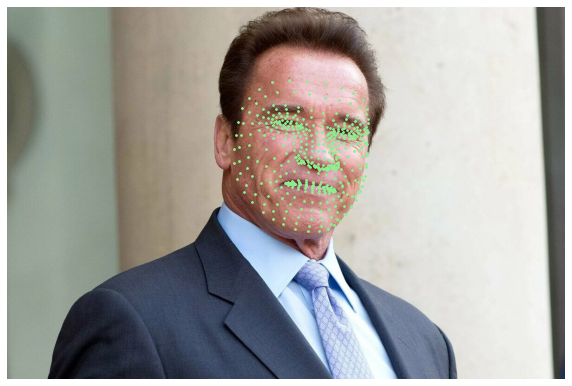

In [5]:
image = cv2.imread(os.path.join(path, "0.jpeg"))
face_batch = model.detect(image)

figure = plt.figure(figsize=(10, 10))
height, width = image.shape[:2]

for face in face_batch:
    plt.scatter(face[:, 0]*width, face[:, 1]*height, c="lightgreen", s=3)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

<blockquote style="border-color: rgba(124,203,234,0.25)">
    <a name="003" style="color: black">
        <p style="padding: 10px;
              font-size:25px;
              font-weight: bolder">
            Basic operations
        </p>
    </a>
</blockquote>

Transformation of the coordinate space allows to detect the coordinates of the face rotated relative to the camera. In the case of orthogonal transformation, the rotation of the head will be described by three rotation matrices around the axes of the Cartesian coordinate system.

In [6]:
def normalize(array: np.ndarray) -> np.ndarray:
    """Normalization and centering of the face from -0.5 to 0.5 in width, height and depth of the face.
    """
    min_value = array.min(axis=0)
    max_value = array.max(axis=0)
    
    return np.absolute(array - min_value) / np.absolute(max_value - min_value) - 0.5

2.1. Original image:


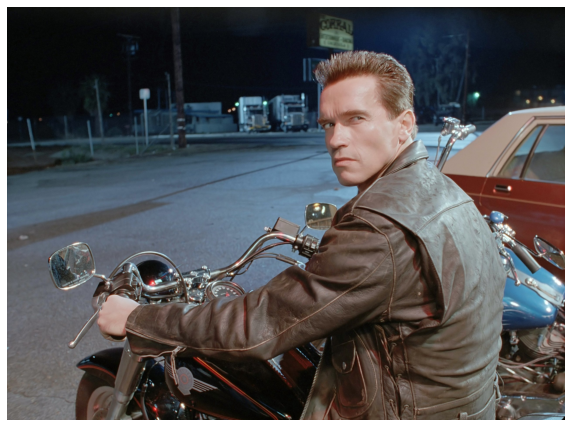

2.2. Extracting facial landmarks from an image with a convolutional neural network:


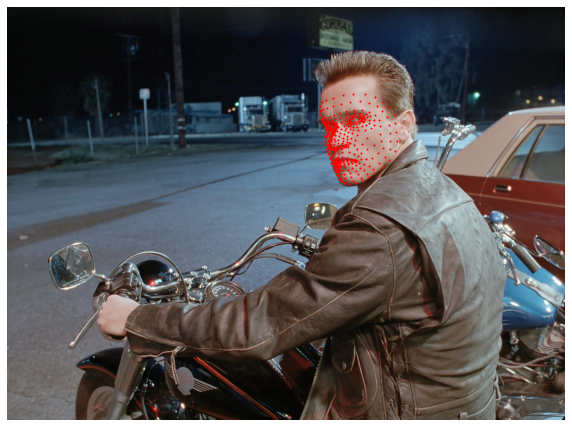

2.3. Normalization and centering of the facial landmarks:


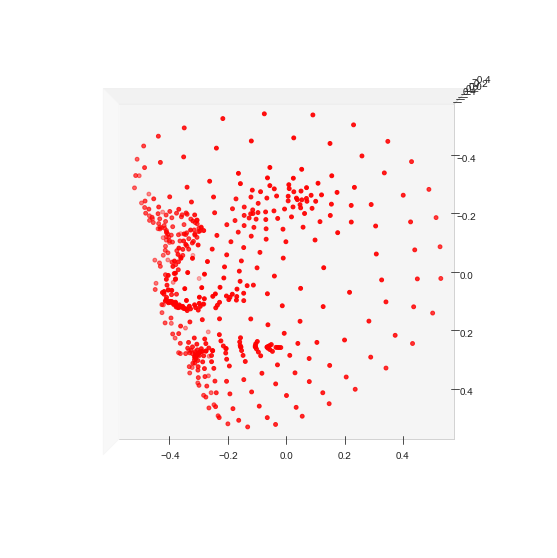

In [7]:
image = cv2.imread(os.path.join(path, "1.jpeg"))
face_batch = model.detect(image)

print('2.1. Original image:')
figure = plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

print('2.2. Extracting facial landmarks from an image with a convolutional neural network:')
figure = plt.figure(figsize=(10, 10))
height, width = image.shape[:2]

for face in face_batch:
    plt.scatter(face[:, 0]*width, face[:, 1]*height, c="red", s=1)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

print('2.3. Normalization and centering of the facial landmarks:')
figure = plt.figure(figsize=(10, 10))
ax = figure.add_subplot(projection="3d")
ax.view_init(elev=-90, azim=-90)

for face in face_batch:
    n_face = normalize(face)
    ax.scatter(xs=n_face[:, 0], ys=n_face[:, 1], zs=n_face[:, 2], c="red", s=15)

ax.grid(False)
plt.show()

Unlike entertainment tasks, facial features obtained by mathematical calculations can be used in more important tasks, for example, classification of emotions and tracking of separate landmarks (eyes, lips) of the user's face, recognition and biometrics of a person.

<blockquote style="border-color: rgba(124,203,234,0.25)">
    <a name="004" style="color: black">
        <p style="padding: 10px;
              font-size:25px;
              font-weight: bolder">
            Tricks
        </p>
    </a>
</blockquote>

Calculation of the vector of facial expressions for the classification of expressions or emotions of a person.

In [8]:
def euclidian_dist(array: np.ndarray) -> np.ndarray:
    """Calculation of Euclidian distance between facial landmarks and the center of the head.
    """
    return np.sqrt(np.sum(np.power(array, 2), axis=1))

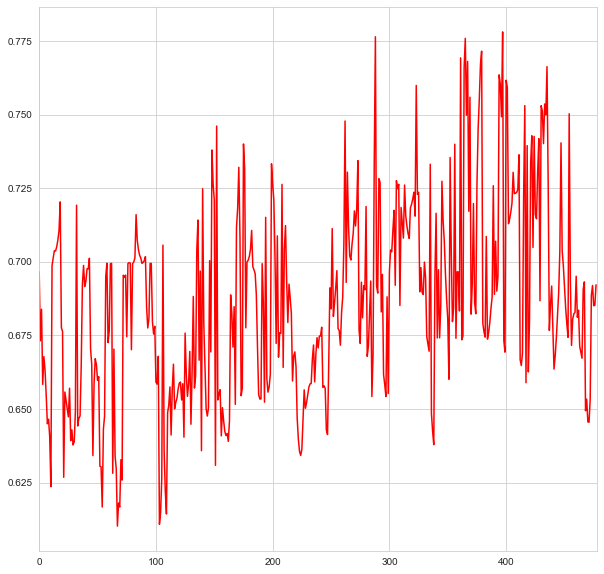

In [9]:
figure = plt.figure(figsize=(10, 10))

for face in face_batch:
    n_face = normalize(face)
    e_dist = euclidian_dist(face)
    plt.plot(e_dist, c="red")

plt.xlim(0, 478)
plt.show()

Recognition of a person by comparing his facial landmarks with the true image.

In [10]:
def distance(embedding1: np.ndarray, embedding2: np.ndarray) -> float:
    """Calculation of distance between detected faces embeddings.
    
    Args:
        embedding1 (np.ndarray): Original face image embedding represented as numpy array.
        embedding2 (np.ndarray): Face image embedding to compare represented as numpy array.
    """
    diff = np.subtract(embedding1, embedding2)
    dist = np.sum(np.square(diff))
    
    return dist

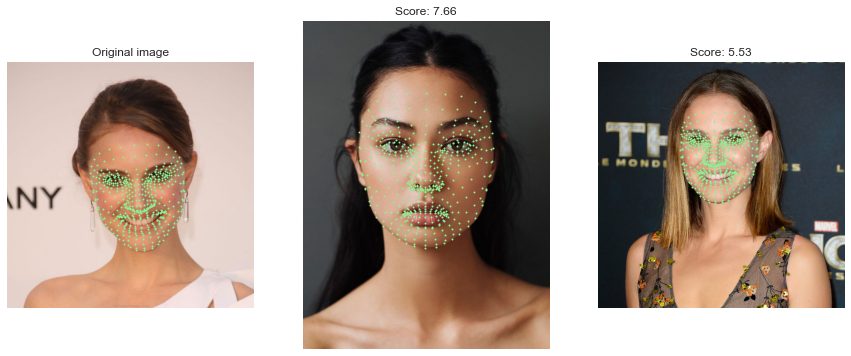

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))

image = cv2.imread(os.path.join(path, "test.jpg"))
face_batch = model.detect(image)
height, width = image.shape[:2]

for face in face_batch:
    n_face = normalize(face)
    ax[0].scatter(face[:, 0]*width, face[:, 1]*height, c="lightgreen", s=1)
ax[0].axis("off")
ax[0].set_title("Original image")
ax[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

image_1 = cv2.imread(os.path.join(path, "test_0.jpg"))
face_batch = model.detect(image_1)

height, width = image_1.shape[:2]

for face in face_batch:
    n_face_1 = normalize(face)
    dist = distance(n_face, n_face_1)
    ax[1].scatter(face[:, 0]*width, face[:, 1]*height, c="lightgreen", s=1)
ax[1].axis("off")
ax[1].set_title(f"Score: {dist:.2f}")
ax[1].imshow(cv2.cvtColor(image_1, cv2.COLOR_BGR2RGB))

image_0 = cv2.imread(os.path.join(path, "test_1.jpg"))
face_batch = model.detect(image_0)
height, width = image_0.shape[:2]

for face in face_batch:
    n_face_0 = normalize(face)
    dist = distance(n_face, n_face_0)
    ax[2].scatter(face[:, 0]*width, face[:, 1]*height, c="lightgreen", s=1)
ax[2].axis("off")
ax[2].set_title(f"Score: {dist:.2f}")
ax[2].imshow(cv2.cvtColor(image_0, cv2.COLOR_BGR2RGB))

plt.show()

<blockquote style="border-color: rgba(124,203,234,0.25)">
    <a name="006" style="color: black">
        <p style="padding: 10px;
              font-size:25px;
              font-weight: bolder">
            Conclusion
        </p>
    </a>
</blockquote>

Open-source solutions, for example BlazeFace, expand the possibilities of face detection and facial features analysis. Moreover, the authors proposed a framework that is optimized for inference on mobile GPUs which increases the range of development and solving important tasks on millions of devices around the world.